# Implementation of 1511.03674

[1511.03674](https://arxiv.org/abs/1511.03674) is the motivation for this work.
It contains an example analysis for Run3 (300/fb), that has a rather simple preselection and adds a few cuts on top.
They are implemented in the notebook below, and make mostly use of the forward jet.

The preselection is discussed as being:
- Same sign leptons
- at least 4 jets (including forward jets), 3 of them central
- at least one b-tagged jets

In order to suppress more ttbar, we require at least 5 jets.

One of the discussed cuts is to ask for a lepton with >100 GeV.
This cut is only ~40% efficient for signal (tW scattering, ttW), and doesn't reject a lot of background.
For now, we don't use it.


In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

from memory_profiler import profile

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.helpers import loadConfig, getCutFlowTable, mergeArray

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [4]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "pt_spec_max" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "eta_spec_max" :          hist.Hist("Counts", dataset_axis, eta_axis),
            "MT" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "ST" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "mbj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mjj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mjj_max_baseline" :  hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_ele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_diele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_dimu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_spec" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "FWMT1" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT2" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT3" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT4" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT5" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "S" :               hist.Hist("Counts", dataset_axis, norm_axis),
            "S_lep" :           hist.Hist("Counts", dataset_axis, norm_axis),
            'diboson':          processor.defaultdict_accumulator(int),
            'ttbar':            processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTZ':              processor.defaultdict_accumulator(int),
            'TTH':              processor.defaultdict_accumulator(int),
            'TTTT':             processor.defaultdict_accumulator(int),
            'tW_scattering':    processor.defaultdict_accumulator(int),
            'DY':               processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## Muons
        muon = Collections(df, "Muon", "tight").get()
        vetomuon = Collections(df, "Muon", "veto").get()
        dimuon = muon.choose(2)
        SSmuon = ( dimuon[(dimuon.i0.charge * dimuon.i1.charge)>0].counts>0 )
        
        ## Electrons
        electron = Collections(df, "Electron", "tight").get()
        vetoelectron = Collections(df, "Electron", "veto").get()
        dielectron = electron.choose(2)
        SSelectron = ( dielectron[(dielectron.i0.charge * dielectron.i1.charge)>0].counts>0 )

        ## E/Mu cross
        dilepton = electron.cross(muon)
        SSdilepton = ( dilepton[(dilepton.i0.charge * dilepton.i1.charge)>0].counts>0 )
        
        ## how to get leading lepton easily? Do I actually care?
        leading_muon = muon[muon.pt.argmax()]
        leading_electron = electron[electron.pt.argmax()]
        
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
        )
        
        jet       = jet[(jet.pt>25) & (jet.jetId>1)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        btag      = jet[(jet.btagDeepB>0.4184) & (abs(jet.eta)<2.4)]
        light     = jet[((jet.btagDeepB<0.4184) & (abs(jet.eta)<2.4)) | (abs(jet.eta)>=2.4)]
        lightCentral = jet[(jet.btagDeepB<0.4184) & (abs(jet.eta)<2.4) & (jet.pt>30)]
        fw        = light[abs(light.eta).argmax()] # the most forward light jet
        
        ## this is my personal forward jet definition, can be used later
        spectator = jet[(abs(jet.eta)>2.0) & (abs(jet.eta)<4.7) & (jet.pt>25) & ( ((jet.puId>6) & (jet.pt<50)) | (jet.pt>50) ) & (jet.jetId>1)] # 40 GeV seemed good. let's try going lower
        leading_spectator = spectator[spectator.pt.argmax()]        


        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]

        ## other variables
        st = df["MET_pt"] + jet.pt.sum() + muon.pt.sum() + electron.pt.sum()
        ht = jet.pt.sum()
        
        ## Event classifieres
        # We want to get the deltaEta between the most forward jet fw and the jet giving the largest invariant mass with fw, fw2
        jj = fw.cross(light)
        deltaEta = abs(fw.eta - jj[jj.mass.argmax()].i1.eta)
        deltaEtaJJMin = ((deltaEta>2).any())
        
        light_light = light.cross(light)
        mjj_max = light_light[light_light.mass.argmax()].mass
        
        ## define selections (maybe move to a different file at some point)
        dilep      = ((electron.counts + muon.counts)==2)
        leppt      = (((electron.pt>25).counts + (muon.pt>25).counts)>0)
        lepveto    = ((vetoelectron.counts + vetomuon.counts)==2)
        SS         = (SSelectron | SSmuon | SSdilepton)
        Mll_veto   = (~(dimuon.mass<125).any() & ~(dielectron.mass<125).any() & ~(dilepton.mass<125).any() )
        Mll_veto2  = (~(abs(dimuon.mass-91.2)<15).any() & ~(abs(dielectron.mass-91.2)<15).any() ) # not so strict Z veto
        nbtag      = (btag.counts>0)
        met        = (met_pt > 50)
        nfwd       = (spectator.counts>0)
        fwdJet50   = ((leading_spectator.pt>50).any())
        ptl100     = (((leading_muon.pt>100).any()) | ((leading_electron.pt>100).any()))
        eta_fwd    = ((abs(light.eta)>1.75).any())

        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = ['tW_scattering', 'TTW', 'TTZ', 'TTH', 'TTTT', 'diboson', 'ttbar', 'DY']
        cutflow = Cutflow(output, df, cfg, processes)
        
        cutflow.addRow( 'dilep',       dilep )
        cutflow.addRow( 'leppt',       leppt )
        cutflow.addRow( 'lepveto',     lepveto )
        cutflow.addRow( 'SS',          SS )
        
        ss_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'njet4',       (jet.counts>=4) )
        cutflow.addRow( 'njet5',       (jet.counts>=5) )
        cutflow.addRow( 'central3',    (lightCentral.counts>=3) ) 
        cutflow.addRow( 'central4',    (lightCentral.counts>=4) ) # not very efficient for signal. lets look at the plot
        cutflow.addRow( 'nbtag',       nbtag )
        #cutflow.addRow( 'lep100',      ptl100 )
        #cutflow.addRow( 'Mll',         Mll_veto2 ) # switched to not so strict Z veto
        cutflow.addRow( 'MET>50',      met )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'eta_fwd',     eta_fwd )
        cutflow.addRow( 'deltaEtaJJ',  deltaEtaJJMin )
        cutflow.addRow( 'ST>500',      (st>500) )
        cutflow.addRow( 'ST>600',      (st>600) )
        cutflow.addRow( 'nfwd',        nfwd )
        cutflow.addRow( 'fwdJet50',    fwdJet50 )

        # preselection of events
        event_selection = cutflow.selection
        
        ### And fill the histograms
        # just the number of electrons and muons
        output['N_ele'].fill(dataset=dataset, multiplicity=electron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_mu'].fill(dataset=dataset, multiplicity=muon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        ## N jet and N b without selections on those
        output['N_jet'].fill(dataset=dataset, multiplicity=jet[dilep].counts, weight=df['weight'][dilep]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[dilep].counts, weight=df['weight'][dilep]*cfg['lumi'])
        ## forward jet properties
        output['N_spec'].fill(dataset=dataset, multiplicity=spectator[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['pt_spec_max'].fill(dataset=dataset, pt=leading_spectator[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['eta_spec_max'].fill(dataset=dataset, eta=leading_spectator[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        
        ## something a bit more tricky
        output['N_diele'].fill(dataset=dataset, multiplicity=dielectron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_dimu'].fill(dataset=dataset, multiplicity=dimuon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])

        output['mjj_max'].fill(dataset=dataset, mass=mjj_max[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mjj_max_baseline'].fill(dataset=dataset, mass=mjj_max[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [5]:
overwrite = True
small = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'strong_tW_small' if small else 'strong_tW'

from samples import fileset, fileset_small, fileset_2l, fileset_SS

# histograms
histograms = []
histograms += ['N_ele', 'N_mu', 'N_diele', 'N_dimu', 'mjj_max', 'mjj_max_baseline', 'pt_spec_max', 'eta_spec_max']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_small
        workers = 4
    else:
        fileset = fileset_SS
        workers = 8
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=500000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()



/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/li

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


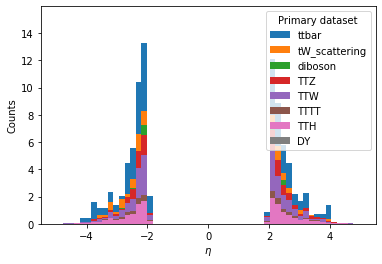

In [4]:
histogram = output['eta_spec_max']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


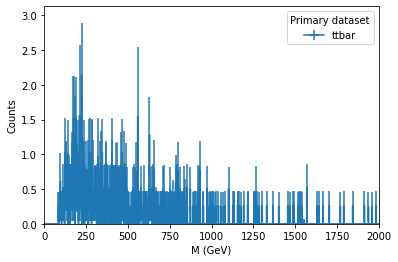

In [5]:
histogram = output['mjj_max_baseline']
ax = hist.plot1d(histogram['ttbar'],overlay="dataset", stack=False)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


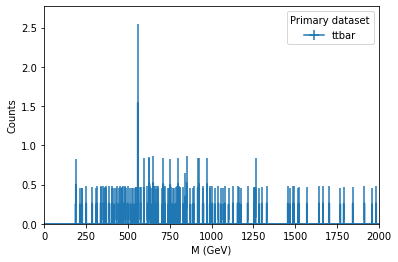

In [6]:
histogram = output['mjj_max']
ax = hist.plot1d(histogram['ttbar'],overlay="dataset", stack=False)

In [6]:
# Cutflow
processes = ['tW_scattering','TTW', 'TTH', 'TTZ', 'TTTT', 'diboson','ttbar', 'DY']
lines = ['entry']
lines += ['dilep', 'leppt', 'lepveto', 'SS', 'njet4', 'njet5', 'central3', 'central4', 'nbtag', 'MET>50', 'eta_fwd', 'deltaEtaJJ', 'ST>500', 'ST>600' ]
lines += ['nfwd', 'fwdJet50'] # those are my cuts
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='tW_scattering')
df

,tW_scattering,TTW,TTH,TTZ,TTTT,diboson,ttbar,DY,S/B
entry,2307.0 +/- 18.0,27870.0 +/- 60.0,19880.0 +/- 10.0,24220.0 +/- 20.0,558.5 +/- 0.7,1083000.0 +/- 1000.0,16640000.0 +/- 0.0,22780000.0 +/- 10000.0,0.0001
dilep,380.3 +/- 7.2,4489.0 +/- 18.0,2930.0 +/- 5.0,8678.0 +/- 10.0,122.7 +/- 0.3,183300.0 +/- 200.0,1456000.0 +/- 1000.0,12610000.0 +/- 10000.0,0.0000
leppt,380.3 +/- 7.2,4489.0 +/- 18.0,2930.0 +/- 5.0,8678.0 +/- 10.0,122.7 +/- 0.3,183300.0 +/- 200.0,1456000.0 +/- 1000.0,12610000.0 +/- 10000.0,0.0000
lepveto,279.8 +/- 6.2,3435.0 +/- 16.0,2085.0 +/- 4.0,5961.0 +/- 9.0,72.72 +/- 0.26,146500.0 +/- 100.0,1224000.0 +/- 1000.0,10800000.0 +/- 10000.0,0.0000
SS,94.19 +/- 3.6,1125.0 +/- 5.0,535.5 +/- 1.8,484.3 +/- 2.4,23.97 +/- 0.15,3926.0 +/- 34.0,5630.0 +/- 54.0,4382.0 +/- 190.0,0.0058
njet4,86.47 +/- 3.41,752.6 +/- 4.0,401.1 +/- 1.6,343.1 +/- 2.0,23.81 +/- 0.15,661.7 +/- 13.5,2828.0 +/- 36.0,650.6 +/- 73.2,0.0153
njet5,68.2 +/- 3.0,423.3 +/- 3.2,271.1 +/- 1.3,217.3 +/- 1.7,23.14 +/- 0.15,237.2 +/- 8.0,1451.0 +/- 24.0,214.1 +/- 42.0,0.0240
central3,48.64 +/- 2.52,284.2 +/- 2.7,201.1 +/- 1.1,143.1 +/- 1.4,19.18 +/- 0.13,169.7 +/- 6.7,992.3 +/- 18.7,140.0 +/- 34.0,0.0250
central4,31.01 +/- 2.0,147.9 +/- 2.0,117.9 +/- 0.9,75.39 +/- 1.03,13.99 +/- 0.12,100.8 +/- 5.1,531.8 +/- 13.0,65.92 +/- 23.31,0.0294
nbtag,24.96 +/- 1.79,113.5 +/- 1.8,91.25 +/- 0.74,56.9 +/- 0.9,13.44 +/- 0.12,8.958 +/- 1.5,320.4 +/- 10.0,0 +/- 0.0,0.0413


In [8]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,tW_scattering,TTW,TTH,TTZ,TTTT,diboson,ttbar,DY
entry,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
dilep,0.140,0.136,0.122,0.322,0.193,0.147,0.071,0.472
lepveto,0.724,0.751,0.688,0.644,0.572,0.777,0.845,0.865
SS,0.334,0.328,0.250,0.077,0.329,0.025,0.004,0.000
njet4,0.924,0.664,0.738,0.708,0.993,0.173,0.494,0.150
njet5,0.787,0.563,0.671,0.635,0.971,0.366,0.515,0.292
central3,0.711,0.674,0.739,0.665,0.829,0.713,0.668,0.737
central4,0.622,0.521,0.584,0.529,0.729,0.595,0.530,0.429
nbtag,0.791,0.763,0.776,0.758,0.959,0.087,0.619,0.000
MET>50,0.774,0.816,0.776,0.739,0.843,0.837,0.670,1.000


We can probably scale up the signal x-sec by ~1.5 (assuming 12% of the inclusive ttW x-sec, compared to the x-sec we currently use 0.12\*0.61/0.0478).
This increases S/B to about 0.10, with ttbar still being the largest contribution of almost 100 events.
Can we use a tighter ID (e.g. ttH/V leptonMVA), or are we missing something?

The theory paper has a lower ttbar rate, but probably a tighter lepton ID (similar signal yield for 300/fb as we have for 137/fb).

We should check:
- which ttX contribution is the largest
- use ttH lepton ID -> should be easy to implement now
- add some plots

In [9]:
from plots.helpers import *
bins = {\
    'N_jet':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{jet}$', 15, -0.5, 14.5)},
    'N_spec':   {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{jet, fwd}$', 6, -0.5, 5.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-jet}$', 5, -0.5, 4.5)},
    'pt_spec_max': {'axis': 'pt',         'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T, fwd jet}\ (GeV)$', 20, 0, 400)},
    'eta_spec_max': {'axis': 'eta',         'overflow':'over',  'bins': hist.Bin('eta', r'$p\eta_{fwd jet}\ (GeV)$', 15, -5.5, 5.5)},
    'mjj_max':  {'axis': 'mass',          'overflow':'over',  'bins': hist.Bin('mass', r'$M(jj) \ (GeV)$', 10, 0, 2000)},
    'mjj_max_baseline':  {'axis': 'mass',          'overflow':'over',  'bins': hist.Bin('mass', r'$M(jj) \ (GeV)$', 10, 0, 2000)},
    }

In [10]:


if output['mjj_max']['pseudodata'].values():
    print ("has it")

Getting pseudo-data


/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarni

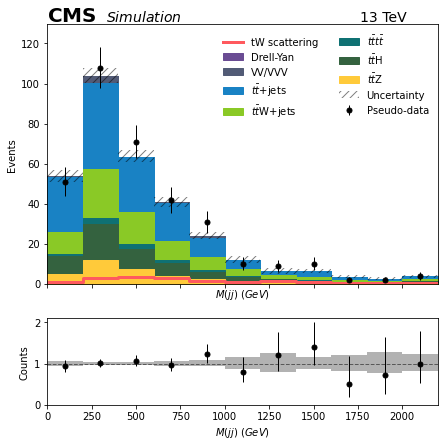

In [11]:
# Make some of the plots. If they look weird, rerun the notebook again - we use a mplhep style for the NLL scan below.

plotDir = os.path.expandvars(cfg['meta']['plots']) + '/dump/'
finalizePlotDir(plotDir)

from plots.helpers import *

if True:
    name = 'mjj_max_baseline'
    #print (name)
    skip = False
    
    # load the cached results
    #output = cache.get('simple_output')
    histogram = output[name]

    axis = bins[name]['axis']
    #print (name, axis)
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    # get pseudo data
    if not histogram['pseudodata'].values():
        print ("Getting pseudo-data")
        bin_values = histogram.axis(axis).centers(overflow=bins[name]['overflow'])
        poisson_means = histogram.sum('dataset').values(overflow=bins[name]['overflow'])[()]
        values = np.repeat(bin_values, np.random.poisson(np.maximum(np.zeros(len(poisson_means)), poisson_means)))
        if axis == 'pt':
            histogram.fill(dataset='pseudodata', pt=values)
        elif axis == 'eta':
            histogram.fill(dataset='pseudodata', eta=values)
        elif axis == 'mass':
            histogram.fill(dataset='pseudodata', mass=values)
        elif axis == 'multiplicity':
            histogram.fill(dataset='pseudodata', multiplicity=values)
        elif axis == 'ht':
            histogram.fill(dataset='pseudodata', ht=values)
        elif axis == 'norm':
            histogram.fill(dataset='pseudodata', norm=values)
        
        # update the cache
        output[name] = histogram
        #cache['simple_output']  = output
        #cache.dump()
        
    else:
        print ("Pseudo-data found in cache")

    
    import re
    bkgonly = re.compile('(?!pseudodata|!tW_scattering)')
    notdata = re.compile('(?!pseudodata)')
    notsignal = re.compile('(?!tW_scattering)')

    fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    #fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkgonly],overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['TTZ', 'TTH', 'TTTT', 'TTW','ttbar','diboson', 'DY']) #error_opts??
    hist.plot1d(histogram['tW_scattering'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)
    hist.plot1d(histogram['pseudodata'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], error_opts=data_err_opts, clear=False)

    ## build ratio
    hist.plotratio(
        num=histogram['pseudodata'].sum("dataset"),
        denom=histogram[bkgonly].sum("dataset"),
        ax=rax,
        error_opts=data_err_opts,
        denom_fill_opts={},
        guide_opts={},
        unc='num',
        overflow=bins[name]['overflow']
    )


    for l in ['linear']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)


## Make some data cards and run the likelihood fit for the M(jj) distribution

As a test we will use the 10 bins of the M(jj) distribution to extract a likelihood ratio. We should be able to find a better variable than M(jj), this is more a proof of concept.

First, we extract the histograms from the processor output and store them in a root file. Then, we create a data card, add some mock-up systematic uncertainties and run the fit with combine.

In [12]:
from Tools.dataCard import *

In [13]:
# get the histograms to write into a root file, which subsequently is picked up by combine
# in order to also get the content of the overflow bins we use a private version of export1d

from Tools.helpers import export1d

def makeCardFromHist(hist_name, nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all'):
    print ("Writing cards using histogram:", hist_name)
    card_dir = os.path.expandvars('$TWHOME/data/cards/')
    if not os.path.isdir(card_dir):
        os.makedirs(card_dir)
    
    data_card = card_dir+hist_name+'_card.txt'
    shape_file = card_dir+hist_name+'_shapes.root'
    
    histogram = output[hist_name]
    histogram = histogram.rebin('mass', bins[hist_name]['bins'])
    
    # scale some processes
    scales = { 
        'ttbar': nonprompt_scale, 
        'tW_scattering': signal_scale,
        'TTW': bkg_scale, # only scale the most important backgrounds
        'TTZ': bkg_scale,
        'TTH': bkg_scale,
    }
    histogram.scale(scales, axis='dataset')
    
    #observation = hist.export1d(histogram['pseudodata'].integrate('dataset'), overflow=overflow)
    observation = export1d(histogram[notdata].integrate('dataset'), overflow=overflow)
    tw          = export1d(histogram['tW_scattering'].integrate('dataset'), overflow=overflow)
    onlyttx     = re.compile('(TTW|TTZ|TTH|TTTT|diboson|DY)')
    bkg         = export1d(histogram[onlyttx].integrate('dataset'), overflow=overflow)
    nonprompt   = export1d(histogram['ttbar'].integrate('dataset'), overflow=overflow)
    
    file = uproot.recreate(shape_file, compression=uproot.ZLIB(4))
    
    file["signal"]    = tw
    file["nonprompt"] = nonprompt
    file["bkg"]       = bkg
    file["data_obs"]  = observation
    
    # Get the total yields to write into a data card
    totals = {}
    
    totals['signal']      = histogram['tW_scattering'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['bkg']         = histogram[onlyttx].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['nonprompt']   = histogram['ttbar'].integrate('dataset').values(overflow=overflow)[()].sum()
    #totals['observation'] = histogram['pseudodata'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['observation'] = histogram[notdata].integrate('dataset').values(overflow=overflow)[()].sum()
    
    print ("{:30}{:.2f}".format("Signal expectation:",totals['signal']) )
    print ("{:30}{:.2f}".format("Non-prompt background:",totals['nonprompt']) )
    print ("{:30}{:.2f}".format("t(t)X(X)/rare background:",totals['bkg']) )
    print ("{:30}{:.2f}".format("Observation:", totals['observation']) )
    
    
    # set up the card
    card = dataCard()
    card.reset()
    card.setPrecision(3)
    
    # add the uncertainties (just flat ones for now)
    card.addUncertainty('lumi', 'lnN')
    card.addUncertainty('ttx', 'lnN')
    card.addUncertainty('fake', 'lnN')
    
    # add the single bin
    card.addBin('Bin0', [ 'bkg', 'nonprompt' ], 'Bin0')
    card.specifyExpectation('Bin0', 'signal', totals['signal'] )
    card.specifyExpectation('Bin0', 'bkg', totals['bkg'] )
    card.specifyExpectation('Bin0', 'nonprompt', totals['nonprompt'] )
    
    # set uncertainties
    card.specifyUncertainty('ttx', 'Bin0', 'bkg', 1.15 )
    card.specifyUncertainty('fake', 'Bin0', 'nonprompt', 1.20 )
    card.specifyFlatUncertainty('lumi', 1.03)
    
    # observation
    card.specifyObservation('Bin0', int(round(totals['observation'],0)))
    
    print ("Done.\n")
    
    return card.writeToFile(data_card, shapeFile=shape_file)


In [14]:
card_SR = makeCardFromHist('mjj_max', overflow='all')
card_SR = makeCardFromHist('mjj_max', nonprompt_scale=0.5, signal_scale=0.12*0.61/0.0478, bkg_scale=1, overflow='all')
card_baseline = makeCardFromHist('mjj_max_baseline', overflow='all')

Writing cards using histogram: mjj_max
Signal expectation:           8.49
Non-prompt background:        34.39
t(t)X(X)/rare background:     45.48
Observation:                  88.37
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/mjj_max_card.txt
Writing cards using histogram: mjj_max
Signal expectation:           13.01
Non-prompt background:        17.20
t(t)X(X)/rare background:     45.48
Observation:                  75.68
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/mjj_max_card.txt
Writing cards using histogram: mjj_max_baseline
Signal expectation:           15.44
Non-prompt background:        139.88
t(t)X(X)/rare background:     179.80
Observation:                  335.12
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home

In [15]:
card = dataCard()
results_SR = card.nllScan(fname=card_SR, rmin=0, rmax=5, npoints=101)
results_baseline = card.nllScan(fname=card_baseline, rmin=0, rmax=5, npoints=101)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/processor/c782f90e-b1d7-466a-a3ed-6e5e9652e327
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/processor/c570af43-aeaf-496a-b59c-2499d3774198


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


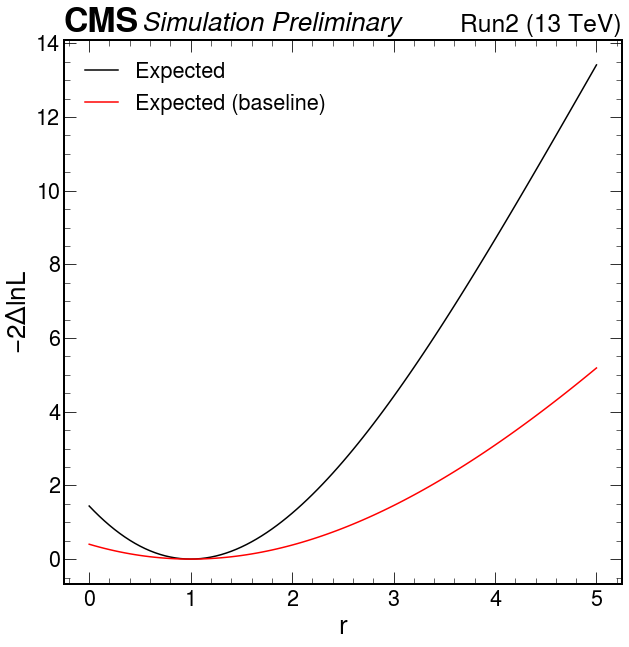

In [16]:
import mplhep
plt.style.use(mplhep.style.CMS)

plt.figure()

plt.plot(results_SR['r'][1:], results_SR['deltaNLL'][1:]*2, label='Expected', c='black')#, linewidths=2)
plt.plot(results_baseline['r'][1:], results_baseline['deltaNLL'][1:]*2, label='Expected (baseline)', c='red')#, linewidths=2)
plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()



plt.style.use(mplhep.cms.style.ROOT)
mplhep.cms.cmslabel(data=False, paper=False, year='Run2')

#mplhep.mpl_magic() ## doesn't really work.

plt.show()

In [17]:
# clean up in case some combine jobs crashed.
card.cleanUp()